<h1><center> EXPERIMENT 6 </h1></center></BR>
<h3> AIM </h3>
To implement Action Recognition Using Inflated 3D CNN
<h3>Theory  </h3>

Action recognition is the process of recognizing human actions in videos. It is a challenging task due to the variability in human actions and the complexity of the video data. One approach to action recognition uses deep learning techniques such as convolutional neural networks (CNNs). One popular CNN architecture for action recognition is the I3D (Inflated 3D) CNN, which is an extension of the popular Inception CNN architecture. The I3D CNN has achieved state-of-the-art performance on several action recognition benchmarks.

The I3D CNN is a two-stream network that consists of a temporal stream and a spatial stream. The temporal stream processes the motion information in videos by stacking multiple frames together to form a "clip" of the video. The spatial stream processes the appearance information in videos by processing individual frames. The two streams are combined through fusion to make the final prediction. The temporal stream uses 3D convolutional layers to capture the motion information in videos. The 3D convolutional layers have three dimensions: height, width, and time. They slide over a 3D volume of data, capturing both spatial and temporal information. The spatial stream uses 2D convolutional layers to capture the appearance information in videos. The 2D convolutional layers have two dimensions: height and width. They slide over a 2D image, capturing only spatial information.
The two streams are combined through fusion to make the final prediction. There are several ways to fuse the two streams, including early fusion, late fusion, and intermediate fusion. Early fusion combines the two streams at the input level, while late fusion combines the two streams at the output level. Intermediate fusion combines the two streams at an intermediate level, such as after the last layer of the two streams.

In TensorFlow, the I3D CNN can be implemented using the pre-trained model provided by Google, which was trained on the Kinetics dataset. The pre-trained model can be fine-tuned on a new dataset by replacing the last classification layer with a new layer that matches the number of classes in the new dataset. The pre-trained model can also be used as a feature extractor by removing the last classification layer and using the output of the second last layer as the feature representation of the video data.
Overall, the I3D CNN is a powerful architecture for action recognition, and its two-stream network with temporal and spatial streams allows it to capture both motion and appearance information in videos.



Here's a step-by-step guide on how to implement I3D CNN using TensorFlow:

1. Download the pre-trained I3D model: Google has released a pre-trained I3D model that is trained on the Kinetics dataset, which contains thousands of action classes. You can download the model from the TensorFlow Hub or from the official GitHub repository.
2. Prepare your data: To train the I3D model on your own dataset, you must prepare your data in the same format as the Kinetics dataset. Each video clip should be saved as a series of JPEG frames in a folder, and each folder should be named after the class label of the video clip.
3. Fine-tune the model: Once you have the pre-trained I3D model and your own dataset, you can fine-tune the model on your dataset. To do this, you need to replace the last classification layer of the model with a new layer that matches the number of classes in your dataset. You can freeze the weights of the pre-trained layers and only train the new layer.
4. Data augmentation: To improve the generalization ability of the model, you can apply data augmentation techniques to your training data. Some common data augmentation techniques for videos include random cropping, flipping, and color jittering.
5. Train the model: Once you have prepared your data and fine-tuned the model, you can start training the model on your dataset. You can use the standard training loop in TensorFlow, and use a suitable optimizer such as Adam or SGD. You can also use early stopping and learning rate scheduling to improve the performance of the model.
6. Evaluate the model: Once the model is trained, you can evaluate its performance on a validation set. You can use metrics such as accuracy, precision, recall, and F1 score to evaluate the performance of the model.



In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [ ]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

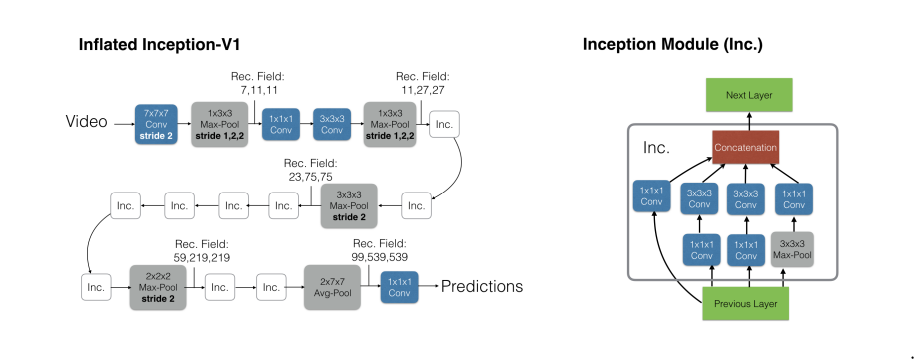

In [ ]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


# Using the UCF101 dataset

In [ ]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()
  
categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


In [ ]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_CricketShot_g04_c02.avi")
sample_video = load_video(video_path)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_CricketShot_g04_c02.avi => /tmp/tmpd_nzisfu/v_CricketShot_g04_c02.avi


In [ ]:
sample_video.shape

(116, 224, 224, 3)

In [ ]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

Run the id3 model and print the top-5 action predictions.

In [ ]:
def predict(sample_video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [ ]:
predict(sample_video)

Top 5 actions:
  playing cricket       : 97.77%
  skateboarding         :  0.71%
  robot dancing         :  0.56%
  roller skating        :  0.56%
  golf putting          :  0.13%


In [ ]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  25.4M      0  0:00:02  0:00:02 --:--:-- 25.4M


In [ ]:
video_path = "End_of_a_jam.ogv"

In [ ]:
sample_video = load_video(video_path)[:100]
sample_video.shape

(100, 224, 224, 3)

In [ ]:
predict(sample_video)

Top 5 actions:
  roller skating        : 96.85%
  playing volleyball    :  1.63%
  skateboarding         :  0.21%
  playing ice hockey    :  0.20%
  playing basketball    :  0.16%


In [ ]:
import matplotlib.pyplot as plt

def predict(sample_video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

  return probabilities.numpy()


In [ ]:
probabilities = predict(sample_video)

Top 5 actions:
  roller skating        : 96.85%
  playing volleyball    :  1.63%
  skateboarding         :  0.21%
  playing ice hockey    :  0.20%
  playing basketball    :  0.16%


Text(0, 0.5, 'Probability')

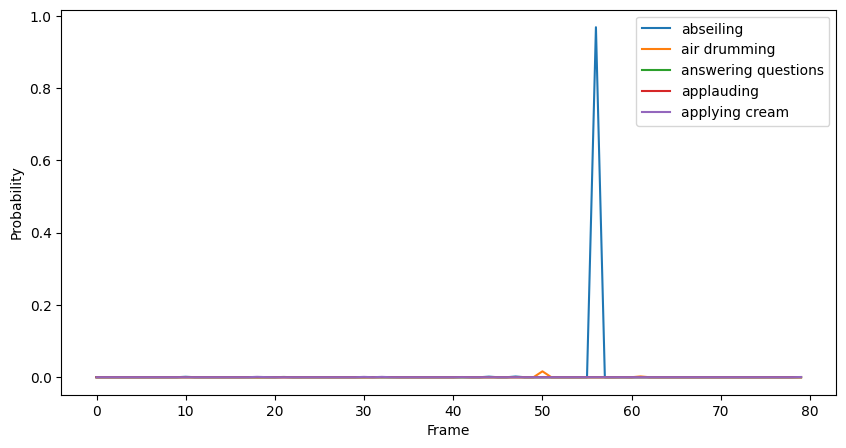

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(probabilities.reshape(-1, 5))
plt.legend(labels[:5])
plt.xlabel('Frame')
plt.ylabel('Probability')


In [ ]:
# Load a set of videos.
videos = ["v_CricketShot_g04_c02.avi", "v_HorseRiding_g09_c03.avi", "v_PlayingPiano_g06_c02.avi", "v_SoccerJuggling_g25_c01.avi", "v_Typing_g01_c02.avi"]
video_paths = [fetch_ucf_video(video) for video in videos]
sample_videos = [load_video(video_path) for video_path in video_paths]


Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_HorseRiding_g09_c03.avi => /tmp/tmpd_nzisfu/v_HorseRiding_g09_c03.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_PlayingPiano_g06_c02.avi => /tmp/tmpd_nzisfu/v_PlayingPiano_g06_c02.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_SoccerJuggling_g25_c01.avi => /tmp/tmpd_nzisfu/v_SoccerJuggling_g25_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Typing_g01_c02.avi => /tmp/tmpd_nzisfu/v_Typing_g01_c02.avi


In [ ]:
# Make predictions on the sample videos.
top5_labels_list = []
top1_probs_list = []

In [ ]:
for sample_video in sample_videos:
  result = predict(sample_video)
  if len(result) == 4:
    top5_labels, _, _, top1_prob = result
    top5_labels_list.append(top5_labels)
    top1_probs_list.append(top1_prob)





Top 5 actions:
  playing cricket       : 97.77%
  skateboarding         :  0.71%
  robot dancing         :  0.56%
  roller skating        :  0.56%
  golf putting          :  0.13%
Top 5 actions:
  riding or walking with horse: 98.30%
  riding mule           :  1.59%
  riding camel          :  0.09%
  jogging               :  0.00%
  walking the dog       :  0.00%
Top 5 actions:
  bandaging             : 36.60%
  smoking               :  2.57%
  stretching arm        :  2.54%
  air drumming          :  2.23%
  rock scissors paper   :  2.13%
Top 5 actions:
  juggling soccer ball  : 98.70%
  dribbling basketball  :  1.17%
  kicking soccer ball   :  0.07%
  shooting goal (soccer):  0.05%
  playing basketball    :  0.01%
Top 5 actions:
  using computer        : 100.00%
  drumming fingers      :  0.00%
  texting               :  0.00%
  using remote controller (not gaming):  0.00%
  recording music       :  0.00%



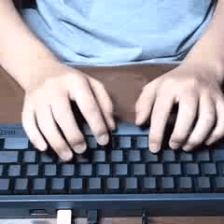

In [ ]:

to_gif(sample_video)

<h3> Conclusion</h3>
Action Recognition Using Inflated 3D CNN is successfully implmented